### Updates
11/14/2020
- in progress: 
 - adding detailed comments to make code more legible
 - cleaning up redundant and unnecessary lines of code
 - replace confusing variables
- coming soon:
 - add email
- still unresolved:
 - the two Georgias ...

In [1]:
import pandas as pd                    # using pandas dataframes is easiest method
import numpy as np                     # numpy provides numerical function and list tools
import matplotlib.pyplot as plt        # required for nice looking plots

The data all comes from the Github repository maintained by Johns Hopkins, https://github.com/CSSEGISandData

In [2]:
# get the data from the Github repository
# the first 4 are from Johns Hopkins CSSE which are the accepted numbers
filepathA = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv"
filepathB = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv"
filepathC = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
filepathD = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
filepathF = "https://raw.githubusercontent.com/umpirsky/country-list/master/data/en_US/country.csv"
filepathG = "https://raw.githubusercontent.com/benhowe75/covid_082020/Latest/country_codes_eu.csv"
filepathH = "https://raw.githubusercontent.com/benhowe75/covid_082020/Latest/state_table.csv"

This block gets lists of states and countries for checking entries later.

In [3]:
states = pd.read_csv(filepathA)
statelist = states.loc[:,"Province_State"].unique()         # get list of all states for reference

countries = pd.read_csv(filepathC)
countrylist = countries.loc[:,"Country/Region"].unique()    # get list of all countries for reference

eu = pd.read_csv(filepathG)
eulist = eu.loc[:,'Country'].unique()                       # get list of EU countries for reference
# eulist = eulist[eulist != ['Albania','Montenegro','Serbia','Turkey']]                 

## Definitions

There are two primary categories, either conformed cases or deaths. Since it is unusual and unwise to compare them, users can choose on eor the other.

In [4]:
def get_choice1():                                                      # get an integer that encodes primary value cases/deaths
    while True:                                                         # this structure ensures only accepted values get through
        try:
            primary = input("Do you want cases or deaths?"
                           "Enter '1' for cases or '2' for deaths. ")   # prompt for user input
            primary = int(primary)                                      # convert input to integer
            if primary == 1 or primary == 2:                              
                break
            else:
                print("choose only 1 for cases or 2 for deaths.")       # display error message and prompt for new value
        except ValueError as e:
            print("Error")
    return(primary)                                                     # return the integer value - 1=cases, 2=deaths

This function makes sure that user choices are countries and states in the database. I don't know what was so special about this block but it took me a long time to get it to respond correctly for names not in either list.

This name block continues to give me problems. I fixed it so that US which gets changed to 'Us' is correctly read as 'US'. There is still the isuue of Georgia being both a state and a country. There are others, I'm certain, that use non-standard latin characters, things like é, œ, or ñ. I think the best way to handle these is to keep track of the exceptions and build a dictionary for those cases.

In [5]:
except_dict ={'Us':'US'}           # dictionary of exceptions - only contains US so far

In [6]:
def check_name(numplaces):                                            # big block to make sure places entered by user are in a db
    j = 0
    while j < numplaces:                                              # while the counter is less than the number of places ...
        try:
            string = input("What's the place?").strip()               # get the place name as string from user and remove any spaces
            string =' '.join(w.capitalize() for w in string.split())  # convert string to 'proper' capitaliation
            if string == 'Us':                                        # if statement to handle US as string
                string = 'US'
                break              
            if string == 'Eu':                                        # if statement to handle EU as string
                string = 'EU'
                break                
            elif string in statelist or string in countrylist:        # look in either list from above for the name
                j += 1                                                # increment the counter
                break
            else:
                print("Pick a better location.")                      # if the place name isn't found prompt user for new one
        except Exception as e:
            print("Error")
    return(string)                                                    # return formatted string name of country or state

I had to add this function as an afterthought to figure out which database to look in for each place.

In [7]:
def get_choice2(name):                 # this function returns an integer encoding secondary value for country/state 
    while True:
        try:
            if name in statelist:       # look in list of states for formatted place name
                secondary = 2           # assign 2 if place is a US state       
            elif name in countrylist:   # look in list of countries for formatted place name
                secondary = 1           # assign 1 if place is a country
            elif name == 'EU':          # handle the special case of EU
                secondary = 1           # assign 1 if place is EU
            else:
                "Something went wrong."
            break
        except ValueError as e:         # exception necessary for try loop
            print("Error")
    return(secondary)                   # returns an integer for each place, 1=country,2=state

This function just gets the right filepath for the given attributes.

In [8]:
def get_data(pair):                         # order of (x,y) is (confirmed/deaths, country/state)
    if pair == (1,1):
        dtable1 = pd.read_csv(filepathC)    # confirmed global
    elif pair == (1,2):
        dtable1 = pd.read_csv(filepathA)    # confirmed US
    elif pair == (2,1):
        dtable1 = pd.read_csv(filepathD)    # deaths global
    else:
        dtable1 = pd.read_csv(filepathB)    # deaths US
    return(dtable1)

This function actually retrieves the specific subset of data for each state. Notice that the databases for deaths and confirmed cases are slightly different, deaths has one more leading column. Why?

In [9]:
def get_state_data(name, dtable, primary):                               # takes name of state, df and value for cases, deaths
    dtable.rename(columns={"Province_State":"State"}, inplace = True)    # rename the column to just 'State'
    
    #place = str(string)
    dtable2 = dtable[dtable.loc[:,'State'] == name]                      # get the relevant row of data for this state
    if primary == 1:                                                     # for some reason db for cases & deaths have different shape
        dtable2 = dtable2.iloc[:,11:]                                    # if cases drop the first 11 columns
    else:
        dtable2 = dtable2.iloc[:,12:]                                    # if deaths drop the first 12 columsn
    return(dtable2)                                                      # returns a df for that state

Same as one above, except for countries.

In [10]:
def get_country_data(name, dtable):                            # takes a place as a string and a dataframe
    place = name.strip()                                       # remove blank spaces around place name
    dtable2 = dtable[dtable.loc[:,'Country/Region'] == place]  # get the correct row of data from table
    dtable2 = dtable2.iloc[:,4:]                               # remove leading columns of trivia
    return(dtable2)                                            # returns df for that country

In [11]:
def get_eu():                                                       # get the data for all EU countries
    eudf = pd.DataFrame()                                           # create empty df
    thepath = filepathC if primary == 1 else filepathD              # select the path cases or deaths db

    thedf = pd.read_csv(thepath)                                    # access the correct db
    for country in eulist:                                          # use EU list from top which can be edited as needed
        countrydf = thedf.loc[thedf['Country/Region'] == country]   # find the row for that country
        countrydf = countrydf.iloc[:,4:]                            # drop the leading columns
        countrydf.loc[country,:] = countrydf.sum(axis = 0)          # sum all the enetries by column
        countrydf = countrydf.iloc[-1,:]                            # drop all except the sum row
        eudf = pd.concat([eudf,countrydf], axis = 1)                # add each country to the growing df as row
    eudf = eudf.transpose()                                         # transpose the df so it matches the others
    eutotal = eudf.sum(axis=0)                                      # finally sum each date and store in new df
    eutotal = pd.DataFrame(eutotal, columns = ['EU'])               # rename the column for plotting purposes

    return(eutotal)

### This is the first time the user has to input anything

In [12]:
primary = get_choice1()                  # get cases or deaths

Do you want cases or deaths?Enter '1' for cases or '2' for deaths.  1


In [13]:
placelist = []                                                           # create empty list of places
while True:
    try:                                                                 # try loop so user enters appropraite value
        numplaces = input("Pick the number of places you want. ")        # prompt for input
        numplaces = int(numplaces)                                       # store value for number of places to compare
        
        i = 0                                                            # set a counter
        if numplaces > 0 and numplaces < 6:                              # limit value of numplaces to 1-5
            while i < numplaces:                                         # loop runs chosen number of times
                place = check_name(numplaces)                            # call check_name function each time
                placelist.append(place)                                  # add formatted name to the empty list
                i += 1                                                   # increment the counter
                continue                                                 # continue = skip to the end and run again
            break                                                        # break = stops loop
        elif numplaces < 1:                                              # if input value is too low
            print("Choose a positive number.")            
        elif numplaces > 5:                                              # if input choice is too high
            print(numplaces, " is too many for a good comparison.")                   
    except ValueError as e:                                              # necessary exception for try loop
        print("Error")

Pick the number of places you want.  5
What's the place? california
What's the place? texas
What's the place? florida
What's the place? new york
What's the place? pennsylvania


This block sums the values for each place and combines it into one dataframe.

In [14]:
combined = pd.DataFrame()                                   # create empty dataframe to hold combined data for all places
for item in placelist:                                      # iterate over strings in placelist
    place     = item                                        # place = place name from list entered by user
    secondary = get_choice2(place)                          # secondary = 1 is country, 2 is state
    primarydf = get_data((primary,secondary))               # finds the right db depending on primary & seocndary values
    
    if item == 'EU':                                        # if one of the names is EU
        db1 = get_eu()                                      # run the get_eu fucntion
    else:
        if secondary == 1:                                  # otherwise for country do these
            db1 = get_country_data(place,primarydf)         # call get_country function for that list item
            db1.loc[place,:] = db1.sum(axis = 0)            # sum the values for each date
            db1 = db1.iloc[-1,:]                            # just keep the summed row
        else:
            db1 = get_state_data(place,primarydf,primary)   # else for state do this
            db1.loc[place,:] = db1.sum(axis = 0)            # sum values for each date
            db1 = db1.iloc[-1,:]                            # keep only total row
    
    combined = pd.concat([combined,db1], axis = 1)          # add the latest df to the combined df

print(combined.head())                                      # display the first 5 rows of the combined df

         California  Texas  Florida  New York  Pennsylvania
1/22/20         0.0    0.0      0.0       0.0           0.0
1/23/20         0.0    0.0      0.0       0.0           0.0
1/24/20         0.0    0.0      0.0       0.0           0.0
1/25/20         0.0    0.0      0.0       0.0           0.0
1/26/20         2.0    0.0      0.0       0.0           0.0


This is a special functiononly for getting NY state data so I can subtract it from total US for visualizing purposes for a look at the rest of the United States.

Block to optionally remove counts for NY state from US data.

In [15]:
def get_ny():                                              # function that just gets NY
    temp_df = get_data((primary,2))                        # primary value is used everywhere
    temp2_df = get_state_data('New York',temp_df,primary)  # run the get_state function
    temp2_df.loc[place,:] = temp2_df.sum(axis = 0)         # perform the usual summation
    temp2_df = temp2_df.iloc[-1,:]                         # remove all but the last row
    
    return(temp2_df)

In [16]:
def us_minus_ny():
    ny1 = get_ny()                                     # call the get_ny function
    us1 = combined['US']                               # access the column for US data
    minus = us1 - ny1                                  # new column = US values minus NY values
    
    combined['US'] = minus                             # replace the old values with the new ones

inpy = 90                                              # initialize the variable 'inpy' (I'm not certain this is needed)
if 'US' in combined.columns:                           # look for a column named 'US' in combined df
    codes = [78,110]                                   # list of ASCII values to check for 78='N' and 110='n'
    while True:
        try:
            inpy = input("Include NY? Press Y/N.")     # get user input
            inpy = ord(inpy)                           # convert character input to integer
            if inpy in codes:                          # look for integer in codes list
                minus_df = us_minus_ny()               # if it's there run the minus_ny function
            else:
                pass                                   # if not, Pass
            break
        except ValueError as e:
            print("Error")  

Block to optionally remove counts for NY state from US data.

In [17]:
def get_uk():                                               # function just to get UK data
    temp_df = get_data((primary,1))                         # use primary value from before
    temp2_df = get_country_data('United Kingdom',temp_df)   # run get_country function
    temp2_df.loc[place,:] = temp2_df.sum(axis = 0)          # sum the columns
    temp2_df = temp2_df.iloc[-1,:]                          # drop all but last row
    
    return(temp2_df)

In [18]:
def us_minus_uk():
    uk1 = get_uk()                                  # call the get_uk function returns a df
    eu1 = combined['EU']                            # access just the column for EU totals
    minus = eu1 - uk1                               # subtract the UK values from EU totals
    
    combined['EU'] = minus                          # replace the old EU totals with the new values less the UK data

inpy = 90                                           # initialize variable 'inpy' with value 90 (letter Z)
if 'EU' in combined.columns:                        # look for column labelled 'EU'
    codes = [78,110]                                # 78 and 110 are 'N' and 'n'
    while True:                                     
        try:
            inpy = input("Include UK? Press Y/N.")  # get user input here, this should only happen if EU is in combined
            inpy = ord(inpy)                        # convert character input to ASCII integer
            if inpy in codes:                       # look for the input in the codes
                minus_df = us_minus_uk()            # if input matches 'N' or 'n' call minus_uk fucntion
            else:
                pass                                # if input doesn't match then Pass
            break                                   # leave the loop
        except ValueError as e:                     # obligatory error message required to make loop run
            print("Error")  

## Now, we can generate rolling averages

These next two blocks I recycled from an earlier program. No sense it reinventing the wheel, right?

In [19]:
N = len(combined)           # get the value for total numer rows in the combined df

In [20]:
def daily(series):                                               # create column of daily increase numbers
    daily = np.zeros(N)                                          # an empty list of zeros
    for i in range(N-1):
        daily[i+1] = round(series.iloc[i+1] - series.iloc[i],2)  # tomorrow count - today count and round to hundredths
    return(daily)                                                # return the list

In [21]:
def seven_day_delta(series):                                                         # generate list of 7-day averages

    seven_day = np.zeros(N)                                                          # a list of zeros to fill with averages
    seven_day_delta = np.zeros(N)                                                    # this is the actual daily increase
    for i in range(N-6):                                                               
        seven_day[i+6] = round((series.iloc[i]+series.iloc[i+1]+series.iloc[i+2]
                                +series.iloc[i+3]+series.iloc[i+4]+series.iloc[i+5]
                                +series.iloc[i+6])/7,2)                              # calculate the average starting on day 7
        seven_day_delta[i+6] = seven_day[i+6]-seven_day[i+5]                         # the 7-day increase is today-yesterday
    return(seven_day_delta)                                                          # return the list

These next two blocks get a place's two letter code for displaying better in tables and plots. 
Note: There are two Georgias - one country, one US state. Are there others?

In [22]:
countryabb = pd.read_csv(filepathF)                  # access the databases of places and abbreviations 
stateabb = pd.read_csv(filepathH)

In [23]:
def get_abbrev(place):                                                            # define a function to get the abbreviations
    try:
        if place in countryabb.values:                                             # look for place in country abbreviations df
            abbv = countryabb.loc[countryabb['value'] == place,'id'].iloc[0]       # select the matching abbreviation
        elif place in stateabb.values:                                             # look in states abbrevaitions df
            abbv = stateabb.loc[stateabb['name'] == place,'abbreviation'].iloc[0]  # select the corresponding abbreviation
        elif place == 'EU':
            abbv = 'EU'                                                            # special case if place is 'EU'
        else:
            abbv = 'XX'                                                            # if place doesn't match anything assign 'XX'
    except IndexError as e:
        abbv = place                                                               # if some error arises just use the place name
    return(abbv)

This cell calls the two functions for daily and 7-day averages and adds them to main dataframe.

In [24]:
step = 1                                               # initialize a counter
for column in combined:                                # loop over the columns of the combined df
    acol = combined.loc[:,column]                      # select columns one by one
    acol1 = daily(acol)                                # call daily function
    acol7 = seven_day_delta(acol)                      # call seven_day_delta function
    
    abb = get_abbrev(column)                           # get the corresponding abbreviations to use as column names
    
    combined.insert(step,"Daily %s" %abb, acol1)       # insert the new columns after the column that was used to generate them
    combined.insert(step+1,"7-day %s" %abb ,acol7)
    step += 3                                          # increment step by 3 (column + daily + 7-day)

In [25]:
print(combined.tail())   # just to make sure stuff is still working

          California  Daily CA  7-day CA      Texas  Daily TX  7-day TX  \
11/11/20    995575.0    6143.0   6379.29  1022336.0   11972.0   8932.14   
11/12/20   1004116.0    8541.0   6751.71  1031363.0    9027.0   8839.00   
11/13/20   1013566.0    9450.0   7193.58  1043116.0   11753.0   9413.43   
11/14/20   1023067.0    9501.0   7672.14  1052229.0    9113.0   9595.43   
11/15/20   1032095.0    9028.0   8483.14  1059753.0    7524.0   9831.86   

           Florida  Daily FL  7-day FL  New York  Daily NY  7-day NY  \
11/11/20  858012.0    5838.0   5269.86  540965.0    4820.0   3592.86   
11/12/20  863619.0    5607.0   5177.00  545762.0    4797.0   3850.00   
11/13/20  870552.0    6933.0   5418.14  551163.0    5401.0   4163.14   
11/14/20  875096.0    4544.0   5431.28  556551.0    5388.0   4420.43   
11/15/20  885201.0   10105.0   5900.58  560200.0    3649.0   4452.00   

          Pennsylvania  Daily PA  7-day PA  
11/11/20      248015.0    3969.0   3590.28  
11/12/20      254155.0    

In [26]:
print(combined.max())

California      1032095.00
Daily CA          15117.00
7-day CA           9560.86
Texas           1059753.00
Daily TX          21771.00
7-day TX          10572.14
Florida          885201.00
Daily FL          15300.00
7-day FL          11870.00
New York         560200.00
Daily NY          11434.00
7-day NY           9908.71
Pennsylvania     268696.00
Daily PA           6140.00
7-day PA           4811.72
dtype: float64


## Population and per capita data

Use the population data to compute per capita cases (cases per thousand people)

In [27]:
# load the population databases into dataframes
# this brings the list of databses available to 9
filepathM = "https://raw.githubusercontent.com/benhowe75/covid_082020/master/country_populations_2019.csv"
filepathN = "https://raw.githubusercontent.com/benhowe75/covid_082020/master/state_populations_2019.csv"
countrypop = pd.read_csv(filepathM)
statepop = pd.read_csv(filepathN)

This is my dictionary so the country names from different databases can match up.

In [28]:
rdict ={'US':'United States', 'Russia':'Russian Federation','Kyrgyzstan':'Kyrgyz Republic','Laos':'Lao PDR'}

In [29]:
def get_population(lst):                                                                      # function to get formatted populations
    pdict = {}                                                                                # empty dictionary
    try:
        for item in lst:                                                                      # the list is list of place names
            if item in rdict:                                                                 # chexk for US & Russia
                item = rdict[item]
            else:
                pass                                                                          # skip
            if item in countrypop.values:                                                     # look in country pop df
                t = countrypop.loc[countrypop['CountryName'] == item,'2019'].iloc[0]          # population value
                p = int(t)                                                                    # convert to integer
                q = countrypop.loc[countrypop['CountryName'] == item, 'CountryCode'].iloc[0]  # retrieve the counrty code from df
            elif item in statepop.values:                                                     # look in state pop df
                t = statepop.loc[statepop['Region'] == item,'2019'].iloc[0]                   # retrieve population value
                p = int(t.replace(',',''))                                                    # remove commas as convert to int
                q = statepop.loc[statepop['Region'] == item, 'Abb'].iloc[0]                   # get the corresponding code
            else:
                p = 1000000                                                                   # if not in list assign a value
                q = item
            #plist.append(p)
            pdict[q] = p                                                                      # add each code:population to dict
    except IndexError as e:
        print("Error")
    return(pdict)                                                                             # return the population dictionary

These two little blocks just retrieves the EU population (does it always include UK?)

In [30]:
eupop = get_population(eulist)       # call get_population2 function
eusum = sum(eupop.values())          # sum all the values for total population
print(eusum)

619065351


In [31]:
pops = get_population(placelist)       # returns dictionary of place:population
if 'EU' in placelist:                  # look for name 'EU' in list of verified names
    pops['EU'] = eusum                 # assign the EU pop from above to pops dictionary
vmax = combined.max()[2::3]            # get the max values from the combined table
latest = combined.iloc[-1,:][2::3]     # get the most recent data from the table

In [32]:
k = 0                                                    # initialize variable k
capl = []                                                # create empty lists
caph = []
for key, value in pops.items():                          # iterate over entries in population dictionary
    cap1 = vmax[k]/value*100000                          # divide each max by 100,000 to compute rate
    caph.append(cap1)                                    # add this value to caph = capita highest
    cap2 = latest[k]/value*100000
    capl.append(cap2)                                    # add this value to capl = capita latest
    k +=1                                                # it's necessary to manually increment the counter
    #print("{:<5}{:10.3}{:10.3}".format(key,cap1,cap2))

This block formats the dataframe to display under the plot

In [33]:
capita = pd.DataFrame(columns = {'Place','Population','Latest 100k','Highest 100k'})   # set up a dataframe with columns
capita['Place'] = placelist                                                            # fill the place column with the full names
capita['Population'] = [v for k,v in pops.items()]                                     # the values from the pop dictionary
capita['Latest 100k'] = capl                                                           # capl and caph values from cell above
capita['Highest 100k'] = caph
capita = capita[['Place','Population','Latest 100k','Highest 100k']]                   # assemble the df

capita['Place'] = capita['Place'].map('{:>14s}'.format)                                # format the data for nice display
capita['Population'] = capita['Population'].map('{:10,d}'.format)
capita['Latest 100k'] = capita['Latest 100k'].map('{:.3f}'.format)
capita['Highest 100k'] = capita['Highest 100k'].map('{:.3f}'.format)

In [34]:
print(capita)

            Place  Population Latest 100k Highest 100k
0      California  39,512,223      21.470       24.197
1           Texas  28,995,881      33.908       36.461
2         Florida  21,477,737      27.473       55.267
3        New York  19,453,561      22.885       50.935
4    Pennsylvania  12,801,989      37.586       37.586


## Plotting the data

Get a start date for plotting. 

In [35]:
import datetime                                                       # need package to handle dates

In [36]:
today = datetime.datetime.today().date()                              # easy to get today's date (just date, no time)
begin = datetime.datetime.strptime("01/22/20","%m/%d/%y").date()      # format an earliest date (just date, no time)

In [37]:
def start_here():                                                               # simplified start date function
    while True:
        try:                                                                    # try loop because dates are tricky
            start = input("Choose start date. \n"
                         "Enter in format mm-dd-yy")                            # user inputs start date
            start = datetime.datetime.strptime(start, "%m-%d-%y").date()        # try to format the date string
            if start < today and start > begin:                                 # if date is between today and begin date
                pass                                                            # then good, skip to end
            else:
                start = datetime.datetime.strptime("4-6-20", "%m-%d-%y").date() # else use 4-6-20 (my birthday)
            break                                                               # terminate loop
        except ValueError as e:                                                 # need exception here
            print("Try again.")
    return(start)

In [38]:
start_date = start_here()                          # call start date function
ndays = (today - start_date).days                  # compute number of elapsed days
mydays = [i for i in range(1,ndays + 1)]           # sequence of integers ndays long 

Choose start date. 
Enter in format mm-dd-yy 8-16-20


In [39]:
def plot_type():                                                                      # function sets plotting parameters
    while True:                                                                       # typical while loop to validate input
        try:
            ptype = input("Enter 1 for 7-day avergages or 2 for cumulative values.")  # get user input
            ptype = int(ptype)                                                        # try to convert input to integer
            if ptype == 1 or ptype == 2:                                              # if value is 1 or 2 then end loop
                break
            else:
                print("Try again")                                                    # if some other number prompt again
        except ValueError:                                                            # if not a number raise exception
            print("Error")
    return(2 if ptype == 2 else 0)                                                    # return either 2 or 0

## Build the plot

Enter 1 for 7-day avergages or 2 for cumulative values. 1
Save plot? Y/N y


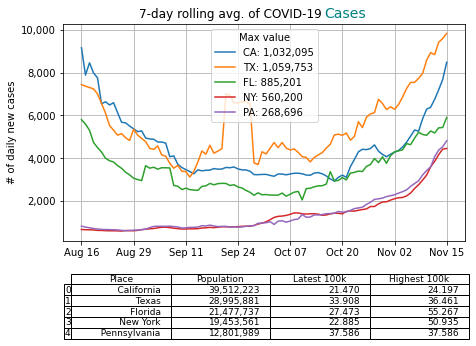

In [40]:
fig, ax = plt.subplots()                                                 # standard declaration to begin plot sequence
labels = []                                                              # empty container for labels

ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
# I borrowed the line above from https://preinventedwheel.com/matplotlib-thousands-separator-1-step-guide/

ref = plot_type()                                                        # call plot_type function

xr = range(2 - ref,len(combined.columns)+1, 3)                           # xr is a range to use in list iterations
xr = xr[:len(placelist)]                                                 # what is this for??

for i in xr:                                                             
    plt.plot(mydays, combined.iloc[-len(mydays):,i])                     # create plots x=mydays, y=row values for each i
    k = 1 if ref == 0 else 0                                             # set this parameter to get correct max value for legend
    lmax = round(combined.iloc[:,i-k-1].max())

    j = i if ref == 0 else i+2                                           # set parameter for generating lables
    labels.append(combined.columns[j][6:] + ": " + "{:,}".format(lmax))  # generate formatted labels

datelist = pd.date_range(start_date, periods=len(mydays)).tolist()       # get list of dates for x-axis
dlist = [d.strftime("%b %d") for d in datelist]                          # format the datelist
divx = len(mydays) // 7                                                  # break the list into 7 equal parts
ax.set_xticks(mydays[0::divx])                                           # create x-ticks
ax.set_xticklabels(dlist[0::divx])                                       # create x-tick labels from dlist

ylbl1 = ('# of daily new %s' % ('deaths' if primary == 2 else 'cases'))  # label for y-axis
ylbl2 = ('# of cumulative %s' % ('deaths' if primary == 2 else 'cases'))
plt.ylabel(ylbl1 if ref == 0 else ylbl2)

title3 = '{:>30s}'.format("7-day rolling avg. of COVID-19 ")                          # different title for each plot type
title4 = '{:>20s}'.format("Cumulative COVID-19  ")
new_title = title3 if ref == 0 else title4                                             
xpos = .30 if ref==0 else .43                                                         # set position of title
plt.figtext(xpos, 0.90, new_title, fontsize='large', color='k', ha ='left')           # place and format tile
plt.figtext(0.73, 0.90,'{:<s}'.format('Deaths' if primary == 2 else 'Cases'),
            fontsize=14, color=('firebrick' if primary == 2 else 'teal'), ha='left')  # place and format descriptive text

# need to add code to indicate UK data excluded
if inpy == 110 or inpy == 78:
    plt.figtext(.425, 0.025, 'US cases don\'t include NY', style = 'italic', color = 'slateblue')
else:
    pass

plt.legend(labels, title = "Max value")                                               # set legends
plt.grid()                                                                            # turn grid on (I always do this)

mpl_table = plt.table(cellText = capita.values, rowLabels = capita.index,             # put population table below plot
                      bbox = [.02, -.45, .99, .30], colLabels=capita.columns)         # the bbox sets the size of the table
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(9)                                                             # manually set font size in table

box = ax.get_position()                                                               # this needed to make it all display properly
ax.set_position([box.x0, box.y0, box.width * 1.2, box.height])

plt.show                                                                              # finally show all the plot elements

savepng = input("Save plot? Y/N")
if ord(savepng) == 89 or ord(savepng) == 121:
    plt.savefig("plot_%s.png" %datetime.datetime.now().strftime("%m%d%Y_%H%M%S"), dpi = 600, bbox_inches = 'tight')
else:
    pass

### Allow user to export data table and plot.

In [41]:
while True:
    try:
        output = input("Do you want to save the table? Press Y/N.")
        output = ord(output)
        if output == 89 or output ==121:
            #plt.savefig("plot_%s.png" %datetime.datetime.now().strftime("%m%d%Y_%H%M%S"), dpi = 600, bbox_inches = 'tight')
            combined.to_csv(r'export_%s.csv' %datetime.datetime.now().strftime("%m%d%Y_%H%M%S"))
            break
        else:
            break
    except ValueError as e:
        print("error")
print("Thank you for using my program. \n"
    "If you see errors or have suggestions email me at benhowe75@outlook.com.")

Do you want to save the table? Press Y/N. y


Thank you for using my program. 
If you see errors or have suggestions email me at benhowe75@outlook.com.
